In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import tellurium as te
import pandas as pd
import functools

from scipy.optimize import differential_evolution as diff_evol

class SpecialDict(dict):
    
    def values(self):
        return list(super().values())
    
% run functions.ipynb

matplotlib.rc('xtick', labelsize=15)     
matplotlib.rc('ytick', labelsize=15)

import scipy.stats

In [3]:
# Load data
R23_amounts = pd.read_csv('estimation/fedbatch_amounts/R23_amounts.csv', index_col=0)
R24_amounts = pd.read_csv('estimation/fedbatch_amounts/R24_amounts.csv', index_col=0)
R23_CO2 = pd.read_csv('online_data/fedbatch/SER_C016_R23.csv')
R24_CO2 = pd.read_csv('online_data/fedbatch/SER_C016_R24.csv')
R23_CO2_selected, mu_R23 = calculate_mu_fedbatch(R23_CO2, 23)
R24_CO2_selected, mu_R24 = calculate_mu_fedbatch(R24_CO2, 24)

In [4]:
mudataframe = pd.DataFrame()
mudataframe['mu'] = mu_R24
mudataframe['Time'] =R24_CO2_selected['Time']
#print(mudataframe[25:67].to_string())
#R23_CO2_selected

In [5]:
mudataframe23 = pd.DataFrame()
mudataframe23['mu'] = mu_R23
mudataframe23['Time'] =R23_CO2_selected['Time']
#print(mudataframe23[25:67].to_string())

In [19]:
mu_model = '''
model *IDModel()

    ######## Set the compartment to 1, otherwise it will be multiplied by the compounds. 
    compartment comp1;
    comp1 =1;


    ######## Specify the species in the compartment
    glucose in comp1; biomass in comp1; serine in comp1; #acetate in comp1


    ######## Constants
    mu_max = 0.2477 # [1/h]
    Ks = 1.4344 # [g/L]
    Ks_qs = 2.6784 # [g/L]
    Ki = 688309 # [g/L]
    qs_max = 1.4075 # (g/(g*h))
    F0 = 0.3
    mu_set = 0.02
    alpha = 1.5007
    beta = 2.7714

    ######## Initial conditions
    V = 0.1021
    glucose = 0 # 0.149770*V # [g]
    biomass = 0.209504 #5.092*V # [g]
    serine = 0 # [g]
    
    ######## Feed function
    Fin := F0*exp(mu_set*time)/1000 # [L/h]
    
    
    ######## Function for volume in fed-batch
    EqVolume: -> V; Fin # [L/h]
    
    ######## Initial concentrations
    c_glucose := glucose/V # [g/L]
    c_glufeed = 415 # [g/L]
    c_biomass := biomass/V



    ######## Functions
    #at (time < 12): #mu = 0.06
    
    
    mu := mu_max*c_glucose/(c_glucose+Ks+(c_glucose^2/Ki)) # [1/h]
    qs := qs_max*c_glucose/(Ks_qs+c_glucose) # [g_substrate/g_biomass h]
    qp := alpha*mu/(mu+beta)
    
    
    ######## Mass Balances 
    eq_biomass: -> biomass; mu*biomass # [g/h]
    eq_glucose: -> glucose; -qs*biomass + Fin*c_glufeed -0.002 # [g/h]  
    eq_serine: -> serine; qp*biomass # [g/h]
    

    end
'''

r = te.loada(mu_model)



#r.exportToSBML('model_and_estimation/model_fedbatch_batchphase.xml')
r.timeCourseSelections = ['time','glucose','biomass','serine','mu', 'Fin', 'V','qs','qp', 'c_glufeed']
results = r.simulate(12.5, 33, 42)

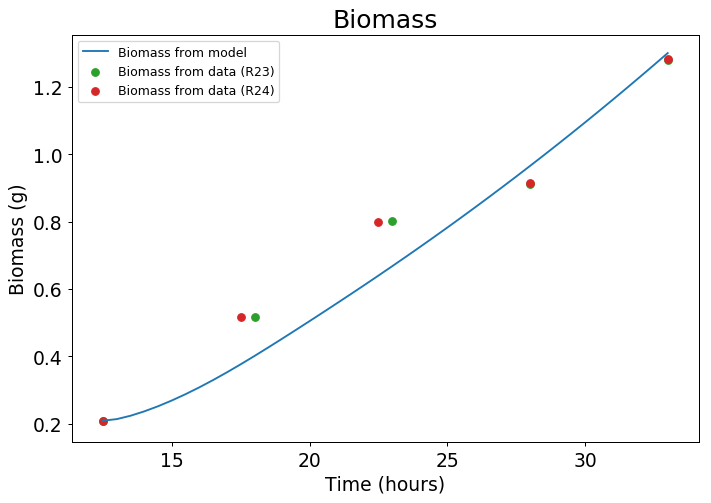

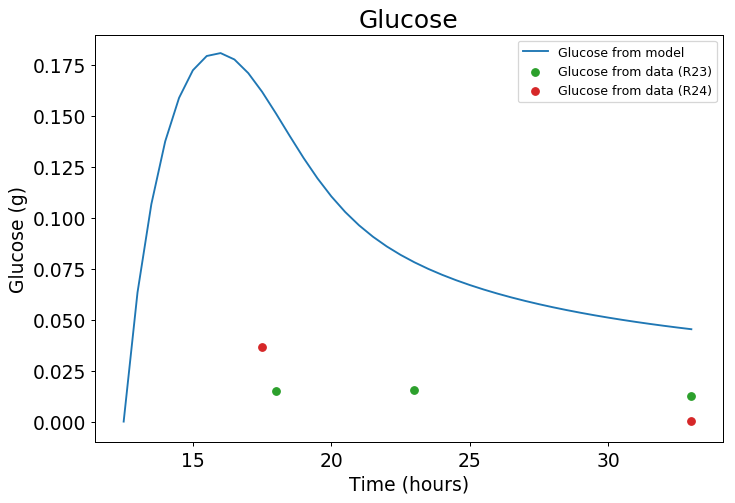

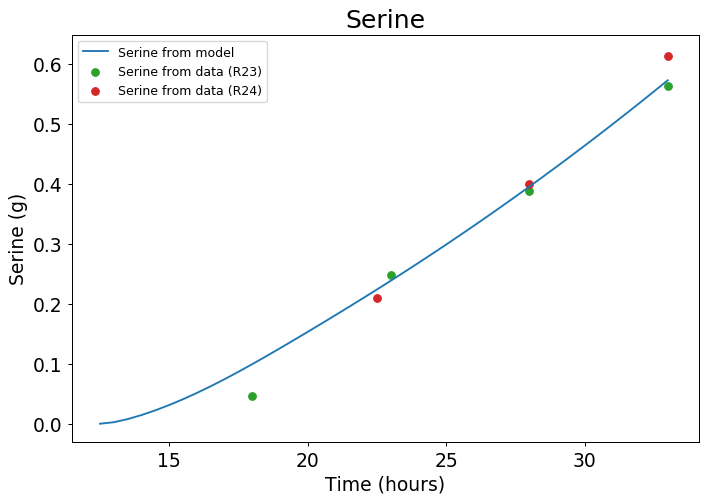

In [20]:
# Plot of the results from the model and the experimental data
plt.figure(num=None, figsize=(9, 6), dpi=90, facecolor='w', edgecolor='k')

plt.plot(results[:, 0], results[:, 2])
plt.scatter(R23_amounts['Time (hours)'][:5], R23_amounts['Biomass (g)'][:5], color = 'C2')
plt.scatter(R24_amounts['Time (hours)'][:5], R24_amounts['Biomass (g)'][:5], color = 'C3')
plt.legend(['Biomass from model', 'Biomass from data (R23)', 'Biomass from data (R24)'], loc='upper left')
plt.xlabel('Time (hours)', fontsize = 15)
plt.ylabel('Biomass (g)', fontsize = 15)
plt.title('Biomass', fontsize = 20)
plt.savefig('figures/modeloutput/fedbatch/estparfedbatch_biomass.png')

plt.show()

plt.figure(num=None, figsize=(9, 6), dpi=90, facecolor='w', edgecolor='k')

plt.plot(results[:, 0], results[:, 1])
plt.scatter(R23_amounts['Time (hours)'][:5], R23_amounts['Glucose (g)'][:5], color = 'C2')
plt.scatter(R24_amounts['Time (hours)'][:5], R24_amounts['Glucose (g)'][:5], color = 'C3')
plt.legend(['Glucose from model', 'Glucose from data (R23)', 'Glucose from data (R24)'], loc='upper right')
plt.xlabel('Time (hours)', fontsize = 15)
plt.ylabel('Glucose (g)', fontsize = 15)
plt.title('Glucose', fontsize = 20)
plt.savefig('figures/modeloutput/fedbatch/estparfedbatch_glucose.png')


plt.show()

plt.figure(num=None, figsize=(9, 6), dpi=90, facecolor='w', edgecolor='k')

plt.plot(results[:, 0], results[:, 3])
plt.scatter(R23_amounts['Time (hours)'][:5], R23_amounts['Serine (g)'][:5], color = 'C2')
plt.scatter(R24_amounts['Time (hours)'][:5], R24_amounts['Serine (g)'][:5], color = 'C3')
plt.legend(['Serine from model', 'Serine from data (R23)', 'Serine from data (R24)'], loc='upper left')
plt.xlabel('Time (hours)', fontsize = 15)
plt.ylabel('Serine (g)', fontsize = 15)
plt.title('Serine', fontsize = 20)
plt.savefig('figures/modeloutput/fedbatch/estparfedbatch_serine.png')


plt.show()

1.0863486930437993 0.01180337778866318 0.9519626564090312 4.764377695858665e-19 0.05992873624846458
1.1222373244170067 0.009348133339323023 0.8774987315227168 2.1650577860041986e-12 0.10518622568184373


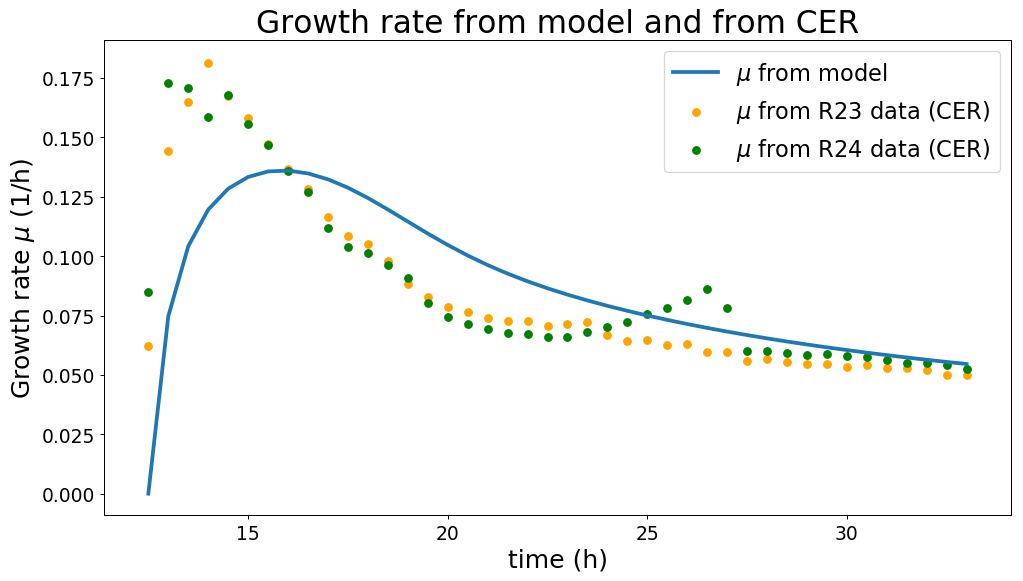

In [22]:
slopeR23, interceptR23, r_valueR23, p_valueR23, std_errR23 = scipy.stats.linregress(mu_R23[31:67], results[6:,4][:])
print(slopeR23, interceptR23, r_valueR23, p_valueR23, std_errR23)

slopeR24, interceptR24, r_valueR24, p_valueR24, std_errR24 = scipy.stats.linregress(mu_R24[31:67], results[6:,4][:])
print(slopeR24, interceptR24, r_valueR24, p_valueR24, std_errR24)


plt.figure(num=None, figsize=(13, 7), dpi=90, facecolor='w', edgecolor='k')
plt.plot(results[:,0],results[:,4], linewidth=3)
plt.scatter(R23_CO2_selected['Time'][25:67], mu_R23[25:67]*slopeR23, color = 'orange')
plt.scatter(R24_CO2_selected['Time'][25:67], mu_R24[25:67]*slopeR24, color = 'green')
plt.xlabel('time (h)', fontsize = 20)
plt.ylabel('Growth rate $\\mu$ (1/h)', fontsize = 20)
plt.legend(['$\\mu$ from model', '$\\mu$ from R23 data (CER)', '$\\mu$ from R24 data (CER)'], loc='upper right', fontsize = 18)
plt.title('Growth rate from model and from CER', fontsize = 25)
plt.savefig('figures/online_integration/growthrates.pdf')


plt.show()

In [134]:
# Average between the slopes
(1.0863486930437993+1.1222373244170067)/2

1.104293008730403

In [135]:
mu_model = '''
model *IDModel()

    ######## Set the compartment to 1, otherwise it will be multiplied by the compounds. 
    compartment comp1;
    comp1 =1;


    ######## Specify the species in the compartment
    glucose in comp1; biomass in comp1; serine in comp1; #acetate in comp1


    ######## Constants
    mu_max = 0.2477 # [1/h]
    Ks = 1.4344 # [g/L]
    Ks_qs = 2.6784 # [g/L]
    Ki = 688309 # [g/L]
    qs_max = 1.4075 # (g/(g*h))
    F0 = 0.3
    mu_set = 0.02
    alpha = 1.5007
    beta = 2.7714

    ######## Initial conditions
    V = 0.1021
    glucose = 0 # 0.149770*V # [g]
    biomass = 0.209504 #5.092*V # [g]
    serine = 0 # [g]
    
    ######## Feed function
    Fin := F0*exp(mu_set*time)/1000 # [L/h]
    
    
    ######## Function for volume in fed-batch
    EqVolume: -> V; Fin # [L/h]
    
    ######## Initial concentrations
    c_glucose := glucose/V # [g/L]
    c_glufeed = 415 # [g/L]
    c_biomass := biomass/V


    ######## Functions
    mu = 0 # [1/h]
    qs := qs_max*c_glucose/(Ks_qs+c_glucose) # [g_substrate/g_biomass h]
    qp := alpha*mu/(mu+beta)
    
    
    ######## Mass Balances 
    eq_biomass: -> biomass; mu*biomass # [g/h]
    eq_glucose: -> glucose; -qs*biomass + Fin*c_glufeed -0.002 # [g/h]  
    eq_serine: -> serine; qp*biomass # [g/h]
    

    end
'''

r = te.loada(mu_model)


#r.exportToSBML('model_and_estimation/model_fedbatch_batchphase.xml')
r.timeCourseSelections = ['time','glucose','biomass','serine','mu', 'Fin', 'V','qs','qp']
results = r.simulate(12.5, 33, 41)

In [136]:
start_time = R23_CO2_selected['Time'][25:67][25]
end_time = R23_CO2_selected['Time'][25:67][26]


r = te.loada(mu_model)
r.mu = 0.057200*1.104293008730403
r.timeCourseSelections = ['time','glucose','biomass','serine','mu']
results = r.simulate(start_time, end_time, 2)

initial_values = results[0:1]
data_frame = pd.DataFrame(initial_values)
data_frame.columns = ['time', 'glucose', 'biomass', 'serine', 'mu']


In [137]:
for i in range(25, 66):
    
    r.mu = 1.104293008730403*mu_R23[25:][i+1]
    glucose = data_frame['glucose'].iloc[-1]
    serine = data_frame['serine'].iloc[-1]
    biomass = data_frame['biomass'].iloc[-1]
    
    start_time = R23_CO2_selected['Time'][25:][i]
    end_time = R23_CO2_selected['Time'][25:][i + 1]
    results = r.simulate(start_time, end_time, 2)
    
    simulated_row = results[-1:]
    new_dataframe = pd.DataFrame(simulated_row)
    new_dataframe.columns = ['time', 'glucose', 'biomass', 'serine', 'mu']
    data_frame = data_frame.append(new_dataframe, ignore_index=True)

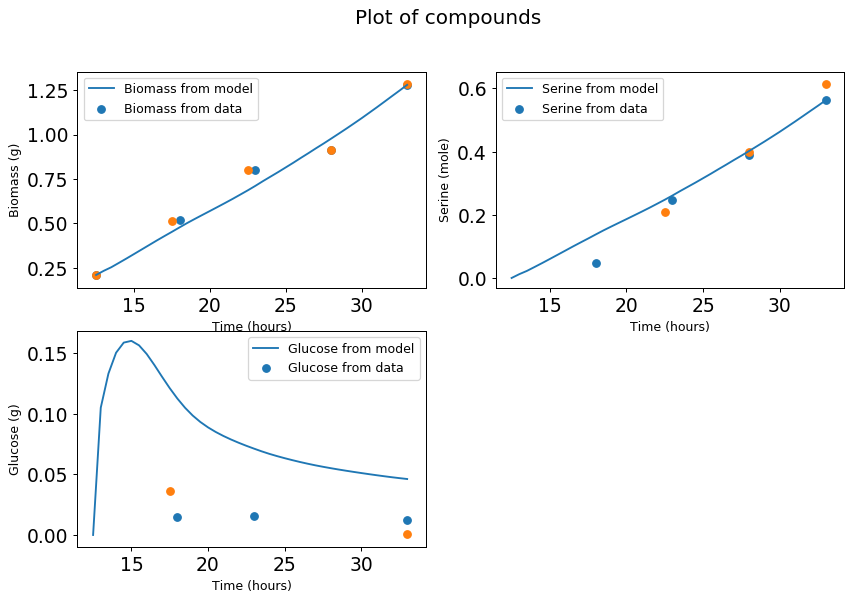

In [138]:
# Plot of the results from the model and the experimental data
plt.figure(num=None, figsize=(11, 7), dpi=90, facecolor='w', edgecolor='k')
plt.suptitle('Plot of compounds', fontsize=16)

plt.subplot(2, 2, 1)
plt.plot(data_frame['time'], data_frame['biomass'])
plt.scatter(R23_amounts['Time (hours)'][:5], R23_amounts['Biomass (g)'][:5])
plt.scatter(R24_amounts['Time (hours)'][:5], R24_amounts['Biomass (g)'][:5])
plt.legend(['Biomass from model', 'Biomass from data'], loc='upper left')
plt.xlabel('Time (hours)')
plt.ylabel('Biomass (g)')

plt.subplot(2, 2, 2)
plt.plot(data_frame['time'], data_frame['serine'])
plt.scatter(R23_amounts['Time (hours)'][:5], R23_amounts['Serine (g)'][:5])
plt.scatter(R24_amounts['Time (hours)'][:5], R24_amounts['Serine (g)'][:5])
plt.legend(['Serine from model', 'Serine from data'], loc='upper left')
plt.xlabel('Time (hours)')
plt.ylabel('Serine (mole)')

plt.subplot(2, 2, 3)
plt.plot(data_frame['time'], data_frame['glucose'])
plt.scatter(R23_amounts['Time (hours)'][:5], R23_amounts['Glucose (g)'][:5])
plt.scatter(R24_amounts['Time (hours)'][:5], R24_amounts['Glucose (g)'][:5])
plt.legend(['Glucose from model', 'Glucose from data'], loc='upper right')
plt.xlabel('Time (hours)')
plt.ylabel('Glucose (g)')

#plt.subplot(2, 2, 4)
#plt.scatter(mu_data_R24['Time (hours)'][25:], mu_data_R24['mu (1/h)'][25:])
#plt.legend(['Growth rate from CER'], loc='upper right')
#plt.xlabel('Time (hours)')
#plt.ylabel('mu (1/h)')



plt.show()

In [139]:
start_time = R24_CO2_selected['Time'][25:67][25]
end_time = R24_CO2_selected['Time'][25:67][26]


r = te.loada(mu_model)
r.mu = 0.075784*1.104293008730403
r.timeCourseSelections = ['time','glucose','biomass','serine','mu']
results = r.simulate(start_time, end_time, 2)

initial_values = results[0:1]
data_frame = pd.DataFrame(initial_values)
data_frame.columns = ['time', 'glucose', 'biomass', 'serine', 'mu']


In [140]:
for i in range(25, 66):
    
    r.mu = 1.104293008730403*(mu_R24[25:])[i+1]
    glucose = data_frame['glucose'].iloc[-1]
    serine = data_frame['serine'].iloc[-1]
    biomass = data_frame['biomass'].iloc[-1]
    
    start_time = R24_CO2_selected['Time'][25:][i]
    end_time = R24_CO2_selected['Time'][25:][i + 1]
    results = r.simulate(start_time, end_time, 2)
    
    simulated_row = results[-1:]
    new_dataframe = pd.DataFrame(simulated_row)
    new_dataframe.columns = ['time', 'glucose', 'biomass', 'serine', 'mu']
    data_frame = data_frame.append(new_dataframe, ignore_index=True)

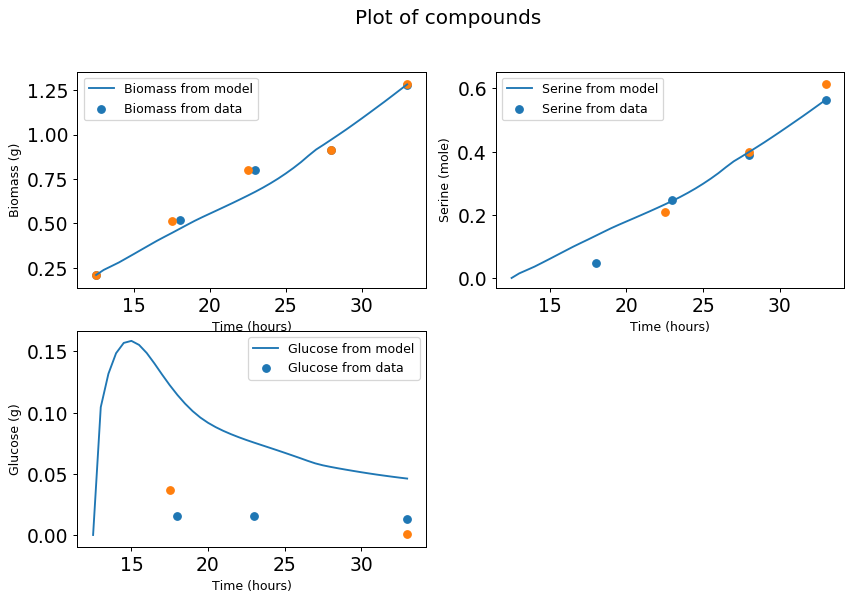

In [141]:
# Plot of the results from the model and the experimental data
plt.figure(num=None, figsize=(11, 7), dpi=90, facecolor='w', edgecolor='k')
plt.suptitle('Plot of compounds', fontsize=16)

plt.subplot(2, 2, 1)
plt.plot(data_frame['time'], data_frame['biomass'])
plt.scatter(R23_amounts['Time (hours)'][:5], R23_amounts['Biomass (g)'][:5])
plt.scatter(R24_amounts['Time (hours)'][:5], R24_amounts['Biomass (g)'][:5])
plt.legend(['Biomass from model', 'Biomass from data'], loc='upper left')
plt.xlabel('Time (hours)')
plt.ylabel('Biomass (g)')

plt.subplot(2, 2, 2)
plt.plot(data_frame['time'], data_frame['serine'])
plt.scatter(R23_amounts['Time (hours)'][:5], R23_amounts['Serine (g)'][:5])
plt.scatter(R24_amounts['Time (hours)'][:5], R24_amounts['Serine (g)'][:5])
plt.legend(['Serine from model', 'Serine from data'], loc='upper left')
plt.xlabel('Time (hours)')
plt.ylabel('Serine (mole)')

plt.subplot(2, 2, 3)
plt.plot(data_frame['time'], data_frame['glucose'])
plt.scatter(R23_amounts['Time (hours)'][:5], R23_amounts['Glucose (g)'][:5])
plt.scatter(R24_amounts['Time (hours)'][:5], R24_amounts['Glucose (g)'][:5])
plt.legend(['Glucose from model', 'Glucose from data'], loc='upper right')
plt.xlabel('Time (hours)')
plt.ylabel('Glucose (g)')

#plt.subplot(2, 2, 4)
#plt.scatter(mu_data_R24['Time (hours)'][25:], mu_data_R24['mu (1/h)'][25:])
#plt.legend(['Growth rate from CER'], loc='upper right')
#plt.xlabel('Time (hours)')
#plt.ylabel('mu (1/h)')



plt.show()

## Fed batch model with batch phase

In [23]:
mu_model = '''
model *IDModel()

    ######## Set the compartment to 1, otherwise it will be multiplied by the compounds. 
    compartment comp1;
    comp1 =1;


    ######## Specify the species in the compartment
    glucose in comp1; biomass in comp1; serine in comp1; #acetate in comp1


    ######## Constants
    mu_max = 0.2477 # [1/h]
    Ks = 1.4344 # [g/L]
    Ks_qs = 2.6784 # [g/L]
    Ki = 688309 # [g/L]
    qs_max = 1.4075 # (g/(g*h))
    F0 = 0.3
    mu_set = 0.02
    alpha = 1.5007
    beta = 2.7714
    switch = 0
    IPTG = 0

    ######## Initial conditions
    V = 0.1021
    glucose = 10*V #0 # 0.149770*V # [g]
    biomass_init = 0.15 # [g/L]
    biomass = biomass_init*V  # [g]
    serine = 0 # [g]
    
    ######## Feed function
    Fin := switch*F0*exp(mu_set*time)/1000 # [L/h]
    
    ######## If fed batch
    at (time > 12.5): switch = 1, IPTG = 1
    
    ######## Function for volume in fed-batch
    EqVolume: -> V; Fin # [L/h]
    
    ######## Initial concentrations
    c_glucose := glucose/V # [g/L]
    c_glufeed = 415 # [g/L]
    c_biomass := biomass/V


    ######## Functions
    mu := mu_max*c_glucose/(c_glucose+Ks+(c_glucose^2/Ki)) # [1/h]
    qs := qs_max*c_glucose/(Ks_qs+c_glucose) # [g_substrate/g_biomass h]
    qp := alpha*mu/(mu+beta)#*IPTG
    
    
    ######## Mass Balances 
    eq_biomass: -> biomass; mu*biomass # [g/h]
    eq_glucose: -> glucose; -qs*biomass + Fin*c_glufeed # [g/h]  
    eq_serine: -> serine; qp*biomass*IPTG # [g/h]
    
    yield := serine/glucose
    qpbio := qp*biomass
    

    end
'''

r = te.loada(mu_model)

#r.exportToSBML('estimation/model_fedbatch_batchphase.xml')
r.timeCourseSelections = ['time','glucose','biomass','serine','mu', 'Fin', 'V','qs','qp','yield','qpbio']
results = r.simulate(0, 33, 67)
#results

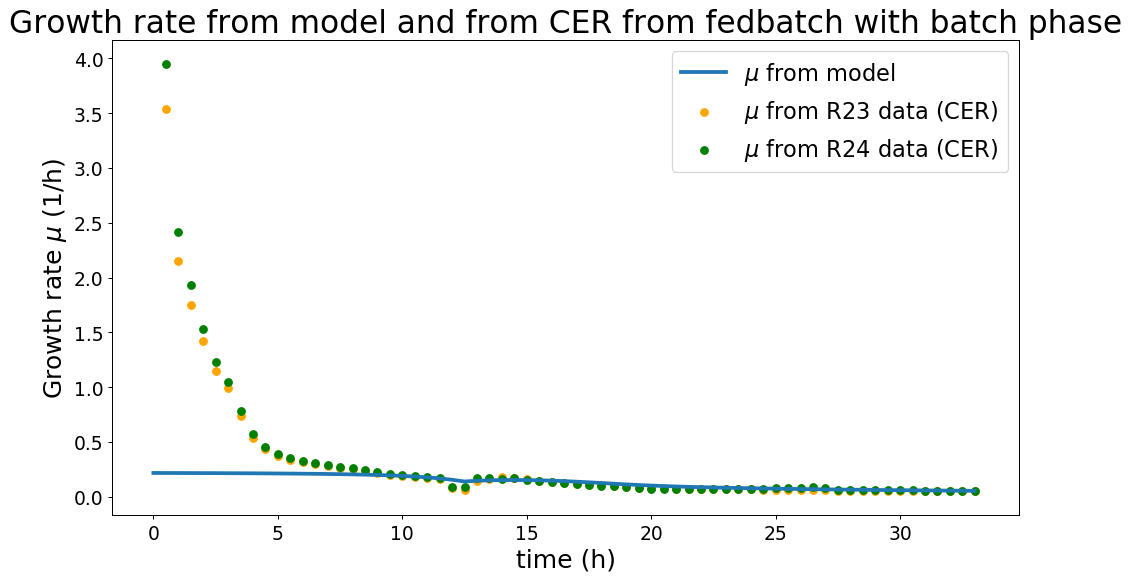

In [24]:
plt.figure(num=None, figsize=(13, 7), dpi=90, facecolor='w', edgecolor='k')
plt.plot(results[:,0],results[:,4], linewidth=3)
plt.scatter(R23_CO2_selected['Time'][:67], mu_R23[:67]*slopeR23, color = 'orange')
plt.scatter(R24_CO2_selected['Time'][:67], mu_R24[:67]*slopeR24, color = 'green')
plt.xlabel('time (h)', fontsize = 20)
plt.ylabel('Growth rate $\\mu$ (1/h)', fontsize = 20)
plt.legend(['$\\mu$ from model', '$\\mu$ from R23 data (CER)', '$\\mu$ from R24 data (CER)'], loc='upper right', fontsize = 18)
plt.title('Growth rate from model and from CER from fedbatch with batch phase', fontsize = 25)
plt.savefig('figures/online_integration/growthrates_batchphase.pdf')


plt.show()

In [102]:
start_time = R24_CO2_selected['Time'][:67][0]
end_time = R24_CO2_selected['Time'][:67][1]


r = te.loada(mu_model)
r.mu = 3.5*1.104293008730403
r.timeCourseSelections = ['time','glucose','biomass','serine','mu']
results = r.simulate(start_time, end_time, 2)

initial_values = results[0:1]
data_frame = pd.DataFrame(initial_values)
data_frame.columns = ['time', 'glucose', 'biomass', 'serine', 'mu']


In [103]:
for i in range(0, 66):
    
    r.mu = 1.104293008730403*(mu_R24[:])[i+1]
    glucose = data_frame['glucose'].iloc[-1]
    serine = data_frame['serine'].iloc[-1]
    biomass = data_frame['biomass'].iloc[-1]
    
    start_time = R24_CO2_selected['Time'][:][i]
    end_time = R24_CO2_selected['Time'][:][i + 1]
    results = r.simulate(start_time, end_time, 2)
    
    simulated_row = results[-1:]
    new_dataframe = pd.DataFrame(simulated_row)
    new_dataframe.columns = ['time', 'glucose', 'biomass', 'serine', 'mu']
    data_frame = data_frame.append(new_dataframe, ignore_index=True)

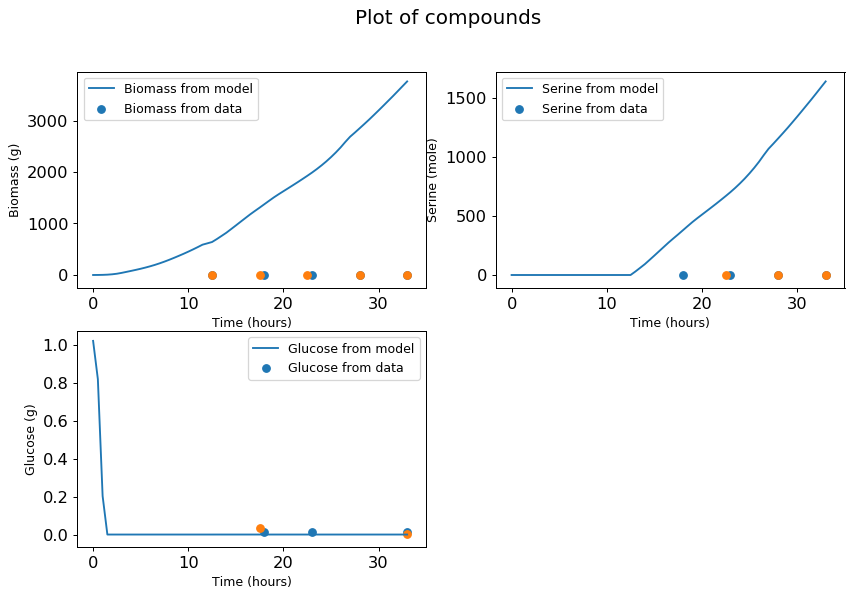

In [104]:
# Plot of the results from the model and the experimental data
plt.figure(num=None, figsize=(11, 7), dpi=90, facecolor='w', edgecolor='k')
plt.suptitle('Plot of compounds', fontsize=16)

plt.subplot(2, 2, 1)
plt.plot(data_frame['time'], data_frame['biomass'])
plt.scatter(R23_amounts['Time (hours)'][:5], R23_amounts['Biomass (g)'][:5])
plt.scatter(R24_amounts['Time (hours)'][:5], R24_amounts['Biomass (g)'][:5])
plt.legend(['Biomass from model', 'Biomass from data'], loc='upper left')
plt.xlabel('Time (hours)')
plt.ylabel('Biomass (g)')

plt.subplot(2, 2, 2)
plt.plot(data_frame['time'], data_frame['serine'])
plt.scatter(R23_amounts['Time (hours)'][:5], R23_amounts['Serine (g)'][:5])
plt.scatter(R24_amounts['Time (hours)'][:5], R24_amounts['Serine (g)'][:5])
plt.legend(['Serine from model', 'Serine from data'], loc='upper left')
plt.xlabel('Time (hours)')
plt.ylabel('Serine (mole)')

plt.subplot(2, 2, 3)
plt.plot(data_frame['time'], data_frame['glucose'])
plt.scatter(R23_amounts['Time (hours)'][:5], R23_amounts['Glucose (g)'][:5])
plt.scatter(R24_amounts['Time (hours)'][:5], R24_amounts['Glucose (g)'][:5])
plt.legend(['Glucose from model', 'Glucose from data'], loc='upper right')
plt.xlabel('Time (hours)')
plt.ylabel('Glucose (g)')

#plt.subplot(2, 2, 4)
#plt.scatter(mu_data_R24['Time (hours)'][25:], mu_data_R24['mu (1/h)'][25:])
#plt.legend(['Growth rate from CER'], loc='upper right')
#plt.xlabel('Time (hours)')
#plt.ylabel('mu (1/h)')



plt.show()